# HM1: Logistic Regression.

### Name: Harris Spahic



#### For this assignment, you will build 6 models. You need to train Logistic Regression/Regularized Logistic Regression each with Batch Gradient Descent, Stochastic Gradient Descent and Mini Batch Gradient Descent. Also, you should plot their objective values versus epochs and compare their training and testing accuracy. You will need to tune the parameters a little bit to obtain reasonable results.

#### You do not have to follow the following procedure. You may implement your own functions and methods, but you need to show your results and plots.

In [ ]:
# Load Packages
import numpy
import pandas as pd
from sklearn.model_selection import train_test_split

import random


# 1. Data processing

- Download the Breast Cancer dataset from canvas or from https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)
- Load the data.
- Preprocess the data.

## 1.1. Load the data

In [ ]:
data = pd.read_csv("data-1.csv")

## 1.2 Examine and clean data

In [ ]:
# Some columns may not be useful for the model (For example, the first column contains ID number which may be irrelavant). 
# You need to get rid of the ID number feature.
# Also you should transform target labels in the second column from 'B' and 'M' to 1 and -1.
data.head()
data = data.drop(columns = ["id", "Unnamed: 32"])

def alter_diagnosis(row):
  if(row.diagnosis == 'M'):
    row.diagnosis = -1
  else:
    row.diagnosis = 1
  return row

data = data.apply(alter_diagnosis, axis="columns")

In [ ]:
print(data)

     diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0           -1        17.99         10.38          122.80     1001.0   
1           -1        20.57         17.77          132.90     1326.0   
2           -1        19.69         21.25          130.00     1203.0   
3           -1        11.42         20.38           77.58      386.1   
4           -1        20.29         14.34          135.10     1297.0   
..         ...          ...           ...             ...        ...   
564         -1        21.56         22.39          142.00     1479.0   
565         -1        20.13         28.25          131.20     1261.0   
566         -1        16.60         28.08          108.30      858.1   
567         -1        20.60         29.33          140.10     1265.0   
568          1         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0            0.11840           0.27760         0.30010  

## 1.3. Partition to training and testing sets

In [ ]:
# You can partition using 80% training data and 20% testing data. It is a commonly used ratio in machine learning.
features = list(data.columns.values)
features.remove("diagnosis")
X = data.loc[:, features]
y = data.loc[:, ["diagnosis"]]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 1.4. Feature scaling

Use the standardization to transform both training and test features

In [ ]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0)
sig = numpy.std(x_train, axis=0)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

x_train, y_train, x_test, y_test = x_train.to_numpy(), y_train.to_numpy(), x_test.to_numpy(), y_test.to_numpy()

test mean = 
radius_mean               -0.011530
texture_mean              -0.049648
perimeter_mean            -0.024278
area_mean                 -0.030448
smoothness_mean           -0.086311
compactness_mean          -0.161125
concavity_mean            -0.173081
concave points_mean       -0.118854
symmetry_mean             -0.164165
fractal_dimension_mean    -0.111343
radius_se                 -0.041021
texture_se                -0.056817
perimeter_se              -0.083738
area_se                   -0.037372
smoothness_se              0.101092
compactness_se            -0.090339
concavity_se              -0.077154
concave points_se          0.026614
symmetry_se               -0.067501
fractal_dimension_se      -0.049114
radius_worst              -0.016442
texture_worst             -0.056242
perimeter_worst           -0.045007
area_worst                -0.030742
smoothness_worst          -0.089337
compactness_worst         -0.183273
concavity_worst           -0.172896
concave points_

# 2.  Logistic Regression Model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

When $\lambda = 0$, the model is a regular logistic regression and when $\lambda > 0$, it essentially becomes a regularized logistic regression.

In [ ]:
# Calculate the objective function value, or loss
# Inputs:
#     w: weight: d-by-1 matrix
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: regularization parameter: scalar
# Return:
#     objective function value, or loss (scalar)

def objective(w, x, y, lam):
    assert(x.shape[0] == y.shape[0])
    assert(x.shape[1] == w.shape[0])

    sum = 0; n = x.shape[0]
    for i in range(n):
      z = numpy.matmul(numpy.multiply(y[i,:], x[i, :]), w)
      result = numpy.log(1 + numpy.exp(-z))
      sum += result

    bias = (lam / 2) * numpy.linalg.norm(w)
    return sum / n + bias

# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ for regularized logistic regression is  $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [ ]:
# Calculate the gradient
# Inputs:
#     w: weight: d-by-1 matrix
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: regularization parameter: scalar
# Return:
#     g: gradient: d-by-1 matrix

def gradient(w, x, y, lam):
    assert(x.shape[0] == y.shape[0])
    assert(x.shape[1] == w.shape[0])

    sum = 0; n = x.shape[0]
    for i in range(n):
      z = numpy.matmul(numpy.multiply(y[i], x[i]), w)
      numerator = numpy.multiply(y[i], x[i])
      sum -= numerator / (1 + numpy.exp(z))
    
    sum = sum/n
    return sum + lam * w

test_weights = numpy.ones(x_train.shape[1])
print(gradient(test_weights, x_train, y_train, 0.5))

[1.13940677 0.87052781 1.15847    1.12395891 0.90443253 1.14821285
 1.21194901 1.25241669 0.88872401 0.64285182 1.01836943 0.53928533
 1.02235917 0.99033007 0.49285693 0.91750294 0.84703261 0.98954383
 0.57139691 0.71992744 1.18492835 0.91531349 1.1996699  1.15143909
 0.93854961 1.12378615 1.1748716  1.26587501 0.93253374 0.91188311]


In [ ]:
# Gradient descent for solving logistic regression
# You will need to do iterative processes (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value

def gradient_descent(x, y, lam, learning_rate, w, max_epoch=100):
    objvals = []
    
    for epoch in range(max_epoch):
      obj = objective(w, x, y, lam)
      w -= gradient(w, x, y, lam) * learning_rate

      objvals.append(obj)

    return w, objvals

Use gradient_descent function to obtain your optimal weights and a list of objective values over each epoch.

In [ ]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.

lgr_weights = numpy.ones(x_train.shape[1])
lgr_weights, lgr_objvals = gradient_descent(x_train, y_train, 0, 0.1, lgr_weights, max_epoch = 100)
print(lgr_objvals)

[14.297006648784398, 13.487196995212255, 12.680314417382805, 11.877529688682587, 11.08026771067247, 10.289585321228493, 9.505916109609336, 8.729583545229339, 7.961259791765186, 7.202209889972502, 6.454555042442677, 5.721607110714859, 5.008154179556991, 4.320756505300139, 3.6681026986839815, 3.061513353415488, 2.5158657802491504, 2.0466014010750095, 1.661304152690012, 1.3563052851493502, 1.1207198911075398, 0.9390293448585079, 0.7973773189093984, 0.6853054391565628, 0.5960466340991138, 0.5249338689093612, 0.46834866826636956, 0.42337017982468056, 0.3875755049687151, 0.358887651803037, 0.3355830477258795, 0.31633416975228706, 0.3001751192454097, 0.2864144202391631, 0.2745502582929078, 0.26420953366798616, 0.25510842360303604, 0.24702713003508658, 0.2397931533599093, 0.23326969330876146, 0.2273472841981949, 0.22193760035976381, 0.21696879473671352, 0.21238195725427442, 0.20812840604292784, 0.2041676038977612, 0.20046554657772966, 0.19699350859680445, 0.1937270609582381, 0.1906452966986202

In [ ]:
# Train regularized logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.

r_lgr_weights = numpy.ones(x_train.shape[1])
r_lgr_weights, r_lgr_objvals = gradient_descent(x_train, y_train, 0.5, 0.1, r_lgr_weights, max_epoch = 100)
print(r_lgr_objvals)


[15.666313042547314, 14.011320638739262, 12.444246935761353, 10.96278546091547, 9.564962798618009, 8.248602625795291, 7.011982294271195, 5.855218642061025, 4.781782954001458, 3.8002586339846856, 2.926046955091574, 2.1830085909598256, 1.600947568062428, 1.1932980160798274, 0.9334798256306005, 0.7711071291917784, 0.6672895214227277, 0.5998210442134725, 0.5548868001261484, 0.5237224600394406, 0.5011728935520138, 0.48426294806374803, 0.4712153322095792, 0.4609174057212312, 0.45264121477484864, 0.4458918780942649, 0.44032179159436846, 0.4356798822105138, 0.43178035348622, 0.4284827497754222, 0.42567885866258687, 0.4232838883057767, 0.4212303943690968, 0.4194640176176768, 0.4179404378227164, 0.4166231590620384, 0.4154818724020859, 0.414491225633583, 0.4136298842303122, 0.4128798037369982, 0.4122256579349839, 0.4116543834962657, 0.4111548130427483, 0.4107173762800135, 0.4103338542912893, 0.40999717589982915, 0.4097012477341495, 0.40944081159681767, 0.4092113241726023, 0.409008855172728, 0.408

## 3.2. Stochastic gradient descent (SGD)

Define new objective function $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $. 

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

You may need to implement a new function to calculate the new objective function and gradients.

In [ ]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: weights: d-by-1 matrix
#     xi: data: 1-by-d matrix
#     yi: label: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i

def stochastic_objective_gradient(w, xi, yi, lam):
    assert(w.shape[0] == xi.shape[0])
    z = numpy.matmul(numpy.multiply(yi, xi), w)
    obj = numpy.log(1 + numpy.exp(-z)) + (lam/2) * numpy.linalg.norm(w)
    g = -(numpy.multiply(yi, xi) / (1 + numpy.exp(z))) + lam * w

    return obj, g

# weights = numpy.ones(x_train.shape[1])
# sum = 0
# for i in range(x_train.shape[0]):
#   sum += stochastic_objective_gradient(weights, x_train[i], y_train[i], 0)[0]

# print(sum / x_train.shape[0])

Hints:
1. In every epoch, randomly permute the $n$ samples.
2. Each epoch has $n$ iterations. In every iteration, use 1 sample, and compute the gradient and objective using the ``stochastic_objective_gradient`` function. In the next iteration, use the next sample, and so on.

In [ ]:
# SGD for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)


def sgd(x, y, lam, learning_rate, w, max_epoch=100):
    objvals = []
    n = x.shape[0]

    for epoch in range(max_epoch):
      obj_sum = 0
      sample_index = numpy.random.permutation(n)
      for i in range(n):
        iter_obj, gradient = stochastic_objective_gradient(w, x[sample_index[i]], y[sample_index[i]], lam)
        w -= learning_rate * gradient
        obj_sum += iter_obj
      objvals.append(obj_sum /n)

    return w, objvals


Use sgd function to obtain your optimal weights and a list of objective values over each epoch.

In [ ]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.

slg_weights = numpy.ones(x_train.shape[1])
slg_weights, slg_obj = sgd(x_train, y_train, 0, 0.001, slg_weights, max_epoch=100)
print(slg_obj)

[12.477689422183477, 8.891199757764635, 5.5028829750330885, 2.6721606813633545, 1.1192485271796973, 0.5640681864950194, 0.3628142297933979, 0.2816767112684658, 0.2402820737641239, 0.21463133611495078, 0.19680282766433252, 0.1833589290100429, 0.17266831155651716, 0.16390481907841076, 0.1565009706050466, 0.15011517109302938, 0.14454694441381932, 0.13965113358443906, 0.13528370811689552, 0.1313737154442717, 0.12786239063009597, 0.12468864256973063, 0.12180218201740431, 0.11916676249450309, 0.11675675033385248, 0.11454000546941231, 0.1124951242633458, 0.11060224475222287, 0.10884947807400577, 0.10721354484234727, 0.10568609666307299, 0.10425717832629647, 0.10291878851811943, 0.1016601872170134, 0.10047449482211351, 0.09935576474380522, 0.09829569514534994, 0.0972953918044822, 0.09634270271463327, 0.09543552453168463, 0.0945724410259415, 0.09374899947322896, 0.09296198301386706, 0.09220764948800331, 0.09148582824742767, 0.09079386809780564, 0.09012689210774269, 0.0894879998477753, 0.0888718

In [ ]:
# Train regularized logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.

slgr_weights = numpy.ones(x_train.shape[1])
slgr_weights, slgr_obj = sgd(x_train, y_train, 0.5, 0.001, slgr_weights, max_epoch=100)
print(slgr_obj)

[12.250871665667013, 6.385229851636004, 2.311550447834774, 0.7778719401852072, 0.5152991033291127, 0.4541049014617086, 0.4307558714281222, 0.4201720243559016, 0.41473296998867093, 0.41178076556248877, 0.4101827946602554, 0.4090643249390571, 0.40873172191587953, 0.40847951643027214, 0.4082596540736584, 0.4080747871659077, 0.4079367945972353, 0.40804631130354846, 0.4079064485728821, 0.40795851950064804, 0.40793944584711983, 0.4077730243235814, 0.40798099979120894, 0.4078245746912622, 0.4078895382735313, 0.4078003778357568, 0.4077534690325691, 0.407861667144938, 0.40779474748668537, 0.4079658140009135, 0.40787436672336413, 0.40796420720576376, 0.4078627052593073, 0.40775774698053446, 0.4078451857867479, 0.4078841858209399, 0.4078520526344476, 0.4078874991176101, 0.4078790932153902, 0.4077705650852803, 0.4078894410009772, 0.40782543428143453, 0.40780999158873155, 0.4079243057367667, 0.40780411240190134, 0.40780361414685196, 0.4078094566610879, 0.40792094213948, 0.4078713067178158, 0.407886

## 3.3 Mini-Batch Gradient Descent (MBGD)

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

You may need to implement a new function to calculate the new objective function and gradients.

In [ ]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: weights: d-by-1 matrix
#     xi: data: b-by-d matrix
#     yi: label: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i

def mb_objective_gradient(w, xi, yi, lam):
    assert(w.shape[0] == xi.shape[1])
    
    obj_sum = 0
    grad_sum = 0
    b = xi.shape[0]

    for i in range(b):
      z = numpy.matmul(numpy.multiply(yi[i], xi[i]), w)
      obj_sum += numpy.log(1 + numpy.exp(-z)) 
      grad_sum = grad_sum - numpy.multiply(yi[i], xi[i]) / (1 + numpy.exp(z))
    
    return (obj_sum + (lam / 2) * numpy.linalg.norm(w))/b, (grad_sum + lam * w)/b 

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.

In [ ]:
# MBGD for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)

def mbgd(x, y, lam, learning_rate, w, max_epoch=100):
    b = 20
    obj_vals = []
    obj_sum = 0

    for epoch in range(max_epoch):
      obj_sum = 0

      for i in range(x.shape[0] // b):
        selected_i = numpy.random.choice(x.shape[0], b)
        xi, yi = x[selected_i, :], y[selected_i, :]
        obj, grad = mb_objective_gradient(w, xi, yi, lam)
        
        w -= learning_rate * grad
        obj_sum += obj

      obj_sum = obj_sum / (x.shape[0] // b)
      
      obj_vals.append(obj_sum)


    return w, obj_vals

Use mbgd function to obtain your optimal weights and a list of objective values over each epoch.

In [ ]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.

mb_weights = numpy.ones(x_train.shape[1])
mb_weights, mb_obj = mbgd(x_train, y_train, 0, 0.02, mb_weights, max_epoch = 100)
print(mb_obj)

[12.77229538345532, 9.186891571270134, 5.795330372578098, 2.9309490408750416, 1.3054625338839276, 0.5599927367388827, 0.3422148755728321, 0.2935039460947751, 0.22963976154369775, 0.22165295747430044, 0.2000243194145498, 0.16556884370549727, 0.1400335765315187, 0.16241226942824633, 0.16124571944548655, 0.1454401054205138, 0.13929877906564578, 0.12220091101815736, 0.11770157308916838, 0.14608189861437937, 0.1277846608928734, 0.13096719584959354, 0.12242367982378834, 0.14657621034587495, 0.13702692405753217, 0.10652635931352043, 0.10849953206878876, 0.09741219859488524, 0.12639403228437696, 0.12263136492077593, 0.1293918385860967, 0.09760067533395357, 0.09866379416831958, 0.09040434936753641, 0.10862316516626955, 0.09237059554642615, 0.09568949647590363, 0.10758521200462559, 0.10243944666183914, 0.10076669301386972, 0.08813505446826009, 0.08658803131025586, 0.09563927682720844, 0.08363897438862233, 0.081683599739371, 0.10162147296144922, 0.09682117164576369, 0.09672353107729147, 0.1163027

In [ ]:
# Train regularized logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.

rmb_weights = numpy.ones(x_train.shape[1])
rmb_weights, rmb_obj = mbgd(x_train, y_train, 0.5, 0.02, rmb_weights, max_epoch = 100)
print(rmb_obj)

[12.647369879471631, 8.293278299171478, 5.6524028513229805, 3.0131822329305398, 1.3351646536973574, 0.6312749310140889, 0.400774842873256, 0.26630617660938494, 0.2594472799518497, 0.2088918416187913, 0.2419521951314044, 0.16977367582640532, 0.2025656993567212, 0.20119900280340025, 0.1889547794728166, 0.16003853737954724, 0.16176140976646122, 0.16662718943895952, 0.15900957886679326, 0.1425502227229947, 0.16922537760461676, 0.16877135986549183, 0.1567170171395924, 0.14603539674307864, 0.13882206161122215, 0.1336220601984042, 0.14986026307966016, 0.1512590198267697, 0.12178656338017374, 0.1419626476625713, 0.13553575616311375, 0.14498115618558366, 0.14079226999662928, 0.14646043508767395, 0.13847299658032605, 0.11229708540294346, 0.12851308215694898, 0.12766183833420294, 0.13462219803787215, 0.12848118984011728, 0.11714647292344095, 0.11825497548377652, 0.139465035242461, 0.11299071739780787, 0.10727083980975792, 0.14030005793322115, 0.12362761706144682, 0.11493580531705766, 0.1216856990

# 4. Compare GD, SGD, MBGD

### Plot objective function values against epochs.

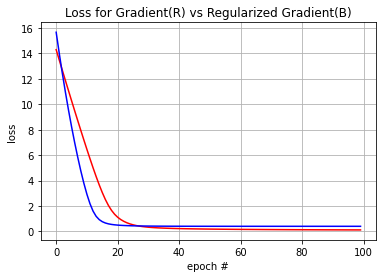

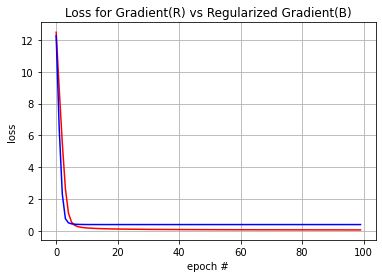

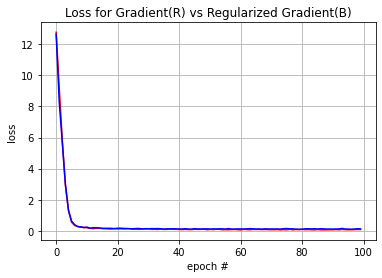

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

lgr_objvals, r_lgr_objvals, slg_obj, slgr_obj, mb_obj, rmb_obj;
epochs = numpy.arange(100)

fig, ax = plt.subplots()
ax.plot(epochs, lgr_objvals, color = "red")
ax.plot(epochs, r_lgr_objvals, color = "blue")
ax.set(xlabel = "epoch #", ylabel = "loss", title = "Loss for Gradient(R) vs Regularized Gradient(B)")
ax.grid()

plt.show()

fig, ax = plt.subplots()
ax.plot(epochs, slg_obj, color = "red")
ax.plot(epochs, slgr_obj, color = "blue")
ax.set(xlabel = "epoch #", ylabel = "loss", title = "Loss for Gradient(R) vs Regularized Gradient(B)")
ax.grid()

plt.show()

fig, ax = plt.subplots()
ax.plot(epochs, mb_obj, color = "red")
ax.plot(epochs, rmb_obj, color = "blue")
ax.set(xlabel = "epoch #", ylabel = "loss", title = "Loss for Gradient(R) vs Regularized Gradient(B)")
ax.grid()

plt.show()


# 5. Prediction
### Compare the training and testing accuracy for logistic regression and regularized logistic regression.

In [ ]:
# Predict class label
# Inputs:
#     w: weights: d-by-1 matrix
#     X: data: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
from decimal import Decimal

def predict(w, X):
    y_pred = numpy.matmul(X, w)
    fix_pred = lambda x: 1 if x > 0 else -1
    y_pred = [fix_pred(x) for x in y_pred]
    
    return y_pred

def calc_accuracy(y_pred, y_train):
    y_train = numpy.squeeze(y_train)
    return Decimal(1 - numpy.count_nonzero(y_train - y_pred) / len(y_pred))

In [ ]:
# evaluate training error of logistic regression and regularized version

print(calc_accuracy(predict(lgr_weights, x_train), y_train))
print(calc_accuracy(predict(r_lgr_weights, x_train), y_train))

print(calc_accuracy(predict(slg_weights, x_train), y_train))
print(calc_accuracy(predict(slgr_weights, x_train), y_train))

print(calc_accuracy(predict(mb_weights, x_train), y_train))
print(calc_accuracy(predict(rmb_weights, x_train), y_train))


0.9516483516483515980866059180698357522487640380859375
0.95824175824175827909101599288987927138805389404296875
0.98681318681318686003578477539122104644775390625
0.95824175824175827909101599288987927138805389404296875
0.98021978021978017903137470057117752730846405029296875
0.984615384615384670041748904623091220855712890625


In [ ]:
# evaluate testing error of logistic regression and regularized version

print(calc_accuracy(predict(lgr_weights, x_test), y_test))
print(calc_accuracy(predict(r_lgr_weights, x_test), y_test))

print(calc_accuracy(predict(slg_weights, x_test), y_test))
print(calc_accuracy(predict(slgr_weights, x_test), y_test))

print(calc_accuracy(predict(mb_weights, x_test), y_test))
print(calc_accuracy(predict(rmb_weights, x_test), y_test))


0.97368421052631581869007959539885632693767547607421875
0.9912280701754385692225923776277340948581695556640625
0.982456140350877138445184755255468189716339111328125
0.9912280701754385692225923776277340948581695556640625
0.982456140350877138445184755255468189716339111328125
0.9912280701754385692225923776277340948581695556640625


# 6. Parameters tuning

### In this section, you may try different combinations of parameters (regularization value, learning rate, etc) to see their effects on the model. (Open ended question)

In [ ]:
# Retrain each model on lower epoch size & larger regularization term

# Normal Gradient Descent
lgr_weights = numpy.ones(x_train.shape[1])
lgr_weights, lgr_objvals = gradient_descent(x_train, y_train, 0, 0.1, lgr_weights, max_epoch = 50)
print(lgr_objvals)

# Regularized Gradient Descent
r_lgr_weights = numpy.ones(x_train.shape[1])
r_lgr_weights, r_lgr_objvals = gradient_descent(x_train, y_train, 1, 0.1, r_lgr_weights, max_epoch = 50)
print(r_lgr_objvals)

# Stochastic Gradient Descent
slg_weights = numpy.ones(x_train.shape[1])
slg_weights, slg_obj = sgd(x_train, y_train, 0, 0.001, slg_weights, max_epoch=50)
print(slg_obj)

# Regularized Stochastic Gradient Descent
slgr_weights = numpy.ones(x_train.shape[1])
slgr_weights, slgr_obj = sgd(x_train, y_train, 1, 0.001, slgr_weights, max_epoch=50)
print(slgr_obj)

# Mini-batch Gradient Descent
mb_weights = numpy.ones(x_train.shape[1])
mb_weights, mb_obj = mbgd(x_train, y_train, 0, 0.02, mb_weights, max_epoch = 50)
print(mb_obj)

# Regularized Mini-batch Gradient Descent
rmb_weights = numpy.ones(x_train.shape[1])
rmb_weights, rmb_obj = mbgd(x_train, y_train, 1, 0.02, rmb_weights, max_epoch = 50)
print(rmb_obj)

[14.297006648784398, 13.487196995212255, 12.680314417382805, 11.877529688682587, 11.08026771067247, 10.289585321228493, 9.505916109609336, 8.729583545229339, 7.961259791765186, 7.202209889972502, 6.454555042442677, 5.721607110714859, 5.008154179556991, 4.320756505300139, 3.6681026986839815, 3.061513353415488, 2.5158657802491504, 2.0466014010750095, 1.661304152690012, 1.3563052851493502, 1.1207198911075398, 0.9390293448585079, 0.7973773189093984, 0.6853054391565628, 0.5960466340991138, 0.5249338689093612, 0.46834866826636956, 0.42337017982468056, 0.3875755049687151, 0.358887651803037, 0.3355830477258795, 0.31633416975228706, 0.3001751192454097, 0.2864144202391631, 0.2745502582929078, 0.26420953366798616, 0.25510842360303604, 0.24702713003508658, 0.2397931533599093, 0.23326969330876146, 0.2273472841981949, 0.22193760035976381, 0.21696879473671352, 0.21238195725427442, 0.20812840604292784, 0.2041676038977612, 0.20046554657772966, 0.19699350859680445, 0.1937270609582381, 0.1906452966986202

In [ ]:
# Adding notes here as I play around with the model above
# Note 1: Regularized term = 5 -> training data loss increases significantly, same with accuracy
# Note 2: Regularized value: 0.5 ~ 1 seems to be consistent
# Note 3: Epochs = 50 significantly improves training accuracy, I find this strange, shouldn't training increase regardless of epoch number
#         and testing accuracy should decrease.
# Result: After checking testing accuracy, ~ 1-2% decrease for all models
#         Not that that accounts for much given how small the data set is & high the accuracy is. There's probably only 1 or 2 datapoints different.

print(calc_accuracy(predict(lgr_weights, x_train), y_train))
print(calc_accuracy(predict(r_lgr_weights, x_train), y_train))

print(calc_accuracy(predict(slg_weights, x_train), y_train))
print(calc_accuracy(predict(slgr_weights, x_train), y_train))

print(calc_accuracy(predict(mb_weights, x_train), y_train))
print(calc_accuracy(predict(rmb_weights, x_train), y_train))

0.91428571428571425716569365249597467482089996337890625
0.9494505494505494080925700473017059266567230224609375
0.97362637362637360904926708826678805053234100341796875
0.9472527472527472180985341765335761010646820068359375
0.97582417582417579904330295903491787612438201904296875
0.97362637362637360904926708826678805053234100341796875


In [ ]:
# evaluate testing error of logistic regression and regularized version

print(calc_accuracy(predict(lgr_weights, x_test), y_test))
print(calc_accuracy(predict(r_lgr_weights, x_test), y_test))

print(calc_accuracy(predict(slg_weights, x_test), y_test))
print(calc_accuracy(predict(slgr_weights, x_test), y_test))

print(calc_accuracy(predict(mb_weights, x_test), y_test))
print(calc_accuracy(predict(rmb_weights, x_test), y_test))

0.9298245614035087758253439460531808435916900634765625
0.97368421052631581869007959539885632693767547607421875
0.982456140350877138445184755255468189716339111328125
0.982456140350877138445184755255468189716339111328125
0.982456140350877138445184755255468189716339111328125
0.9912280701754385692225923776277340948581695556640625
